# UCI Irvine Diabetes Dataset AIM94

## Background and Objective

The dataset analyzed here was collected for the 1994 AI in Medicine Symposium and is hosted at the UCI Irvine Machine Learning Repository.  The dataset contains blood glucose and other measurements for 70 patients with Insulin Dependent Diabetes Mellitus (IDDM).  So what we are dealing with here is time series data with somewhat fictitious uniform time stamps for part of the data set.  

To summarize in layman's terms, both high and low blood glucose levels are very unhealthy for the diabetes patient.  

My objective in analyzing this dataset is to see if I can fit a simple linear model that will look for secular (consistently increasing or decreasing) trendds in the time series data.  A secular trend in the wrong direction would indicate that the patient needs attention.

## References

1.  https://archive.ics.uci.edu/ml/datasets/Diabetes
2.  AIM-94 data set provided by Michael Kahn, MD, PhD, Washington University, St. Louis, MO 

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ggplot import *
import sklearn as sk
from sklearn_pandas import DataFrameMapper, cross_val_score
import datetime as dt
from dateutil.parser import parse as date_parse

pd.options.display.max_columns = 50
pd.options.mode.chained_assignment = None

## Read and Parse Data

In [2]:
df_raw = pd.read_table('diabetes.txt', names = ['id', 'date', 'time', 'code', 'value'])

In [3]:
df_raw.head()

,id,date,time,code,value
0,1,04-21-1991,9:09,58,100
1,1,04-21-1991,9:09,33,009
2,1,04-21-1991,9:09,34,013
3,1,04-21-1991,17:08,62,119
4,1,04-21-1991,17:08,33,007


In [4]:
df_raw.dtypes

id        int64
date     object
time     object
code      int64
value    object
dtype: object

Cannot convert values to_numeric() here because some of them are things like "hi" and "lo". Need to filter down to blood glucose measurements first.

Key to code fields below.  Note that we have categorical variables in this dataset (hypoglycemic symptoms, etc.).  The Code field is deciphered as follows:

33 = Regular insulin dose  
34 = NPH insulin dose  
35 = UltraLente insulin dose  
48 = Unspecified blood glucose measurement  
57 = Unspecified blood glucose measurement  
58 = Pre-breakfast blood glucose measurement  
59 = Post-breakfast blood glucose measurement  
60 = Pre-lunch blood glucose measurement  
61 = Post-lunch blood glucose measurement  
62 = Pre-supper blood glucose measurement  
63 = Post-supper blood glucose measurement  
64 = Pre-snack blood glucose measurement  
65 = Hypoglycemic symptoms  
66 = Typical meal ingestion  
67 = More-than-usual meal ingestion  
68 = Less-than-usual meal ingestion  
69 = Typical exercise activity  
70 = More-than-usual exercise activity  
71 = Less-than-usual exercise activity  
72 = Unspecified special event  

## Filter and Clean Data

Filter down to blood glucose measurements only.

In [5]:
df_bg = df_raw[(df_raw['code'] >= 48) & (df_raw['code'] <= 64)]

In [6]:
df_bg.head()

,id,date,time,code,value
0,1,04-21-1991,9:09,58,100
3,1,04-21-1991,17:08,62,119
5,1,04-21-1991,22:51,48,123
6,1,04-22-1991,7:35,58,216
10,1,04-22-1991,16:56,62,211


Below, errors = 'coerce' forces numeric conversion without errors, inserting NaN (not a number) if it cannot convert.

In [7]:
df_bg['val'] = pd.to_numeric(df_bg['value'], errors = 'coerce')

In [8]:
df_bg[df_bg['val'].isnull()]

,id,date,time,code,value,val
1112,2,10-31-1989,12:00,60,0Hi,NaN
1146,2,11-04-1989,18:00,62,0Hi,NaN
1152,2,11-05-1989,12:00,60,0Hi,NaN
1160,2,11-06-1989,12:00,60,0Hi,NaN
1164,2,11-06-1989,22:00,48,0Hi,NaN
1178,2,11-08-1989,18:00,62,0Lo,NaN
1554,2,12-25-1989,22:00,48,0Hi,NaN
16466,40,11-06-1989,11:00,57,0'',NaN


Gotta clean up that dirty data.

In [9]:
df_bg = df_bg[df_bg['val'].notnull()]

Filter down to blood glucose measurements that are high or low.  

In [10]:
df_high = df_bg[df_bg['val'] >= 250]

In [11]:
df_low = df_bg[df_bg['val'] <= 80]

## Look for Secular Trend in Data, start with one patient

Now look for a secular trend.  We want to know if they lows are decreasing over time (or the highs increasing) for each particular patient ID.  

In [12]:
len(df_high[df_high['id'] == 1])

51

I want to extract each patient's blood glucose data into a separate data structure.  In this case, Y = blood glucose and X = time.  I need to pull out Y and X for each patient, run OLS, and check results for slope.  Let's do it just for patient id = 1 for now.  

In [13]:
df_1 = df_high[df_high['id'] == 1]

In [14]:
df_1.head()

,id,date,time,code,value,val
12,1,04-23-1991,7:25,58,257,257
22,1,04-24-1991,22:09,48,340,340
30,1,04-25-1991,21:54,48,288,288
38,1,04-27-1991,10:03,58,259,259
41,1,04-27-1991,17:20,62,256,256


I really want a single datetime instead of date and time.  

In [15]:
df_1['timestamp'] = df_1['date'] + ' ' + df_1['time']

In [16]:
df_1['datetime'] = pd.to_datetime(df_1['timestamp'])

Now I really want an epoch.

In [17]:
df_1.dtypes

id                    int64
date                 object
time                 object
code                  int64
value                object
val                 float64
timestamp            object
datetime     datetime64[ns]
dtype: object

In [18]:
df_1['epoch'] = df_1['datetime'].astype(np.int64) // 10**9

In [19]:
df_1.head()

,id,date,time,code,value,val,timestamp,datetime,epoch
12,1,04-23-1991,7:25,58,257,257,04-23-1991 7:25,1991-04-23 07:25:00,672391500
22,1,04-24-1991,22:09,48,340,340,04-24-1991 22:09,1991-04-24 22:09:00,672530940
30,1,04-25-1991,21:54,48,288,288,04-25-1991 21:54,1991-04-25 21:54:00,672616440
38,1,04-27-1991,10:03,58,259,259,04-27-1991 10:03,1991-04-27 10:03:00,672746580
41,1,04-27-1991,17:20,62,256,256,04-27-1991 17:20,1991-04-27 17:20:00,672772800


/Users/jonneff/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


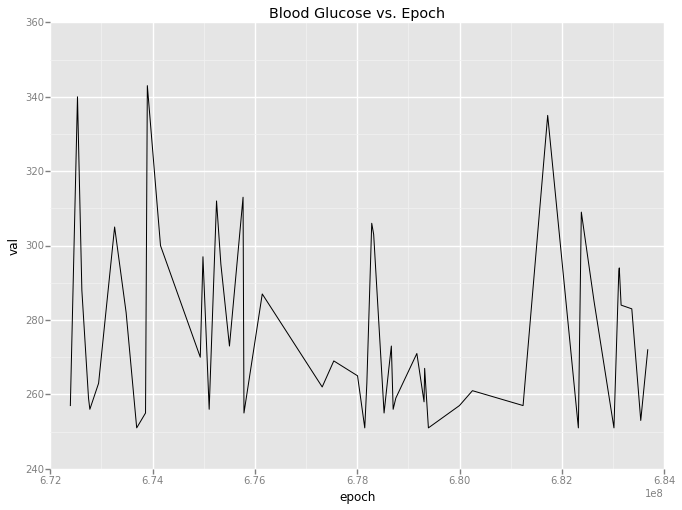

<ggplot: (279192749)>

In [20]:
ggplot(df_1, aes(x='epoch', 
           y='val')) + geom_line(stat='identity') + ggtitle(
            'Blood Glucose vs. Epoch')

In [21]:
x = df_1['epoch']
df_1
y = df_1['val']
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit(method='qr')

In [23]:
prediction = results.predict(exog=x)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    val   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.6810
Date:                Thu, 11 Feb 2016   Prob (F-statistic):              0.413
Time:                        07:13:27   Log-Likelihood:                -234.71
No. Observations:                  51   AIC:                             473.4
Df Residuals:                      49   BIC:                             477.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        821.6138    660.159      1.245      0.2

OK the fit is lousy, this is not very linear, but the slope is negative.  Let's see the linear model and actual data together.

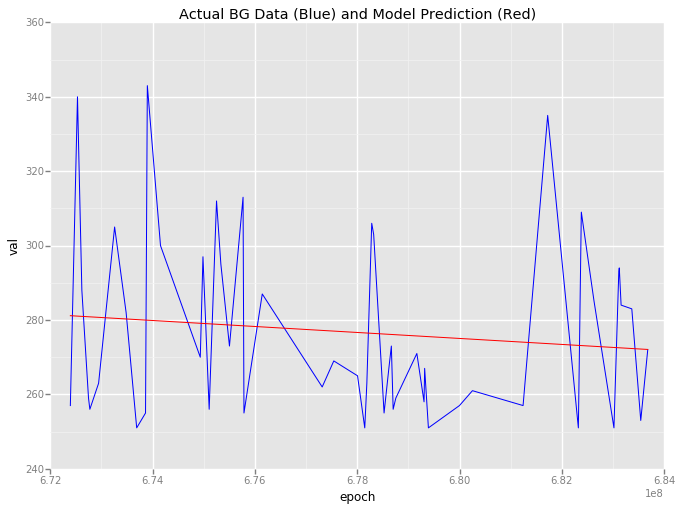

<ggplot: (279565857)>

In [24]:
df_1['pred'] = prediction
ggplot(df_1, aes(x = 'epoch')) + geom_line(
  aes(y = 'val', colour = "blue")
    ) + geom_line(aes(y = 'pred', colour = "red")) + ggtitle(
            'Actual BG Data (Blue) and Model Prediction (Red)')

In [25]:
list(results.params)

[821.6137613509087, -8.0378213099268631e-07]

## Look for Secular Trends for All Patients

So now we can iterate through all of the "high" data and get a list of slopes for each patient, then check to see if any of them are positive.  The positive slopes would indicate that the patient's blood glucose is not under control and needs attention.  

First, get epoch for all points in dataset.

In [26]:
def add_epoch(df):
    df['timestamp'] = df['date'] + ' ' + df['time']
    df['datetime'] = pd.to_datetime(df['timestamp'])
    df['epoch'] = df['datetime'].astype(np.int64) // 10**9
    return df

In [27]:
df_high = add_epoch(df_high)

In [28]:
df_high.head()

,id,date,time,code,value,val,timestamp,datetime,epoch
12,1,04-23-1991,7:25,58,257,257,04-23-1991 7:25,1991-04-23 07:25:00,672391500
22,1,04-24-1991,22:09,48,340,340,04-24-1991 22:09,1991-04-24 22:09:00,672530940
30,1,04-25-1991,21:54,48,288,288,04-25-1991 21:54,1991-04-25 21:54:00,672616440
38,1,04-27-1991,10:03,58,259,259,04-27-1991 10:03,1991-04-27 10:03:00,672746580
41,1,04-27-1991,17:20,62,256,256,04-27-1991 17:20,1991-04-27 17:20:00,672772800


In [29]:
def findslope(df):
    x = df['epoch']
    y = df['val']
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    results = model.fit(method='qr')
    coeffs = list(results.params)
    return coeffs[1]

In [30]:
def getslopes(df_in):
    slopes = [None] # shift index so index = patient ID
    for i in range(1, 71):
        # print i
        df = df_in[df_in['id'] == i]
        if len(df) <= 1:
            slopes.append(None) # Need at least 2 data points for ols linear fit
        else:
            slopes.append(findslope(df))
    return slopes

In [31]:
slopes_high = getslopes(df_high)

In [32]:
print slopes_high

[None, -8.0378213099268631e-07, -2.2464706388811591e-06, 7.4526457248426215e-06, 8.273957643395628e-07, 5.093786279592985e-06, 3.9435352448547172e-06, 5.4768103137027428e-06, -5.1938943976353993e-07, -1.0180551995281651e-05, 9.2091634100730616e-06, -1.1111676326635401e-06, 4.6128232442457007e-06, -1.917424549088985e-05, -8.4033075114249059e-06, 5.4384291182310734e-06, 1.200427825754859e-05, 5.6995757948234385e-06, -8.084076296587994e-06, 2.1882596678222678e-05, -2.7560054683421804e-06, 3.0065806662516968e-06, -7.6749961261260884e-06, -1.0288761489054745e-05, 9.5657405976164506e-06, 2.1757412546435753e-05, -9.2925853040210418e-07, -3.9630074107221443e-05, -1.1413513545389397e-06, 1.3406958582196523e-06, -2.439918919418504e-06, 2.1559503825876045e-06, -5.6389233802068131e-05, 1.5225099915804962e-06, -6.0656546962127901e-06, -2.9295090749635332e-06, 6.9065516795538188e-06, -4.5388954248709678e-06, 1.106869148829599e-05, -2.4299781546886435e-07, -9.6881876841574592e-05, -2.1508532966029688

In [33]:
for i in range(1, 71):
    if slopes_high[i] > 0:
        print 'Patient ID ' + str(i) + ' needs attention, high BG increasing over time'

Patient ID 3 needs attention, high BG increasing over time
Patient ID 4 needs attention, high BG increasing over time
Patient ID 5 needs attention, high BG increasing over time
Patient ID 6 needs attention, high BG increasing over time
Patient ID 7 needs attention, high BG increasing over time
Patient ID 10 needs attention, high BG increasing over time
Patient ID 12 needs attention, high BG increasing over time
Patient ID 15 needs attention, high BG increasing over time
Patient ID 16 needs attention, high BG increasing over time
Patient ID 17 needs attention, high BG increasing over time
Patient ID 19 needs attention, high BG increasing over time
Patient ID 21 needs attention, high BG increasing over time
Patient ID 24 needs attention, high BG increasing over time
Patient ID 25 needs attention, high BG increasing over time
Patient ID 29 needs attention, high BG increasing over time
Patient ID 31 needs attention, high BG increasing over time
Patient ID 33 needs attention, high BG increa

And now the same for the low BG measurements.

In [34]:
df_low = add_epoch(df_low)

In [35]:
slopes_low = getslopes(df_low)

In [36]:
for i in range(1, 71):
    if slopes_low[i] < 0:
        print 'Patient ID ' + str(i) + ' needs attention, low BG decreasing over time'

Patient ID 3 needs attention, low BG decreasing over time
Patient ID 5 needs attention, low BG decreasing over time
Patient ID 6 needs attention, low BG decreasing over time
Patient ID 11 needs attention, low BG decreasing over time
Patient ID 15 needs attention, low BG decreasing over time
Patient ID 17 needs attention, low BG decreasing over time
Patient ID 19 needs attention, low BG decreasing over time
Patient ID 21 needs attention, low BG decreasing over time
Patient ID 22 needs attention, low BG decreasing over time
Patient ID 24 needs attention, low BG decreasing over time
Patient ID 26 needs attention, low BG decreasing over time
Patient ID 27 needs attention, low BG decreasing over time
Patient ID 31 needs attention, low BG decreasing over time
Patient ID 32 needs attention, low BG decreasing over time
Patient ID 34 needs attention, low BG decreasing over time
Patient ID 35 needs attention, low BG decreasing over time
Patient ID 37 needs attention, low BG decreasing over time


Looks like some overlap here.  What if both the highs and lows are out of control?  

In [37]:
for i in range(1, 71):
    if slopes_high[i] > 0 and slopes_low[i] < 0:
        print 'Patient ID ' + str(i) + ' needs attention, high and low BG getting worse over time'

Patient ID 3 needs attention, high and low BG getting worse over time
Patient ID 5 needs attention, high and low BG getting worse over time
Patient ID 6 needs attention, high and low BG getting worse over time
Patient ID 15 needs attention, high and low BG getting worse over time
Patient ID 17 needs attention, high and low BG getting worse over time
Patient ID 19 needs attention, high and low BG getting worse over time
Patient ID 21 needs attention, high and low BG getting worse over time
Patient ID 24 needs attention, high and low BG getting worse over time
Patient ID 31 needs attention, high and low BG getting worse over time
Patient ID 43 needs attention, high and low BG getting worse over time
Patient ID 46 needs attention, high and low BG getting worse over time
Patient ID 62 needs attention, high and low BG getting worse over time


## Write datasets to file

In [38]:
df_bg.to_csv("blood_glucose.csv", header = True)
df_high.to_csv("blood_glucose_high.csv", header = True)
df_low.to_csv("blood_glucose_low.csv", header = True)